This notebook aims to contain all the functions that will permit to apply bias correction.

TO DO :

NEED TO CHECK FUNCTIONALITY OF THE CODE for other methods than bscd precipitation
apply cdf for quantile ..
impose a version for the past and for the future (without y test, not used for BC, just for presentation of results)

In [1]:
# function to calculte return period

from scipy import stats
from scipy.stats import gumbel_r
from scipy.stats import gumbel_l

# function qui marche pour precipitation return period


def threshold_coresponding_to_return_period(loc,scale,T):
    p_non_exceedance = 1 - (1/T)
    try:
        threshold_coresponding = round(gumbel_r.ppf(p_non_exceedance,loc,scale))
    except OverflowError: # the result is not finite
        if math.isinf(gumbel_r.ppf(p_non_exceedance,loc,scale)) and gumbel_r.ppf(p_non_exceedance,loc,scale)<0:
            # ppf is the inverse of cdf
            # the result is -inf
            threshold_coresponding = 0 # the value of wero is imposed
    return threshold_coresponding

from Functions_Indicators import add_year_month_season # need to add conversion of time

# BIAS CORRECTION - POINT WISE METHOD

[Scikit-downscale](https://github.com/pangeo-data/scikit-downscale/tree/main)
[Detailed process here](https://github.com/pangeo-data/scikit-downscale/blob/main/examples/2020ECAHM-scikit-downscale.ipynb)

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


import numpy as np
import pandas as pd
import scipy
import xarray as xr
import os
import os.path

import warnings
warnings.filterwarnings("ignore")  # sklearn

import matplotlib.pyplot as plt
import seaborn as sns



# exploratory data analysis for arrm model
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
# train_test_split Quick utility that wraps input validation and
#    ``next(ShuffleSplit().split(X, y))`` and application to input data
#    into a single call for splitting (and optionally subsampling) data in a
#    oneliner.
#    Returns
#    -------
#    splitting : list, length=2 * len(arrays)
#        List containing train-test split of inputs.

#        .. versionadded:: 0.16
#            If the input is sparse, the output will be a
#            ``scipy.sparse.csr_matrix``. Else, output type is the same as the
#            input type.

#from utils import get_sample_data

from sklearn.preprocessing import KBinsDiscretizer
# use for discretization

sns.set(style='darkgrid')

In [3]:
# function to prepare data for the fitting
def treat_data_for_test(df_obs,name_col_obs,df_model_past,name_col_model,name_station,model):
    
    if 'pr' in name_col_model.lower():
        new_name = 'pcp'
    
    # prepare training data
    df_model_past_BC=df_model_past[df_model_past['Name station']==name_station].drop(['Name station','Year','Month','Season'],axis =1)
    df_model_past_BC = df_model_past_BC[df_model_past_BC['Model'] ==model].drop(['Model','Experiment','Latitude','Longitude'],axis=1)
    training = df_model_past_BC.rename(columns = {'Date':'time',name_col_model:new_name}).reset_index(drop=True)
    
    Date1 = training['time'].values
    for i in np.arange(0,len(training)):
        training['time'][i] = Date1[i][6:10]+'-'+Date1[i][3:5]+'-'+Date1[i][0:2]#datetime.strptime(, '%Y-%M-%d').date()
        #print(training['time'][i])
    # .date() to avoid having the hours in the datetime
    training=training.set_index('time')
    
    # prepare targets data
    targets = df_obs[['NAME','DATE',name_col_obs]] # select only 3 columns of interest
    targets = targets[targets['NAME']==name_station].rename(columns = {'DATE':'time',name_col_obs:new_name}).set_index('time').drop(['NAME'],axis=1) # the targets data is meant to represent our "observations"
    
    if len(targets)>len(training):
        targets = targets.dropna() # drop rows with NaN
        training = training[training.index.isin(list(targets.index))]
    if len(targets)<len(training):
        training = training.dropna() # drop rows with NaN
        targets = targets[targets.index.isin(list(training.index))]
    
    # concat training and target data in one dataframe
    df=pd.concat({'training': training, 'targets': targets}, axis=1)
    df=df.dropna()
    
    return df

In [26]:
# df_obs and df_model should be under a dataframe format, with no nan values, with a common timelaps, with the data as a string format '%Y-%m-%d', and as index

# Method could be :
#        piecewise_regressor
#        Quantile_Linear_Regression

def BC(df,name_col,method):
    
    if method == 'piecewise_regressor':
        (X_train, X_test, y_train, y_test,pred)=piecewise_regressor(df,name_col)
    if method == 'Quantile_Linear_Regression':
        (X_train, X_test, y_train, y_test,pred)=Quantile_Linear_Regression(df,name_col)
    if method == 'Bcsd_Precipitation':
        (X_train, X_test, y_train, y_test,pred)=BCSD_Precipitation(df)
    return (X_train, X_test, y_train, y_test,pred)
    plot_train_test(X_train, X_test, y_train, y_test)
    plot_train_test_pred(X_train, X_test, y_train, y_test,pred)
    plot_test_pred(X_test,y_test, y_train, pred)
    
    out = plot_cdfs(X_test,y_test,pred)
    return out 

In [5]:
def piecewise_regressor(df,name_col):
    from mlinsights.mlmodel import PiecewiseRegressor # in piecewise estimator
    #     Uses a :epkg:`decision tree` to split the space of features
    #    into buckets and trains a linear regression (default) on each of them.
    #    The second estimator is usually a :epkg:`sklearn:linear_model:LinearRegression`.
    #    It can also be :epkg:`sklearn:dummy:DummyRegressor` to just get
    #    the average on each bucket.
    
    X = df[('training',name_col)][min(df.index)[0:4]: max(df.index)[0:4]].values#training[[name_col]]['1980': '2000'].values
    y = df[('targets',name_col)][min(df.index)[0:4]: max(df.index)[0:4]].values#targets[[name_col]]['1980': '2000'].values
    
    X_train, X_test, y_train, y_test = train_test_split(X, y)# splits data
    
    # parameters for Quantile transforms
    qqwargs = {'n_quantiles': int(1e6), 'copy': True, 'subsample': int(1e6)} # add int for n_quantiles and subsample to avoid
    # following problem:  InvalidParameterError: The 'n_quantiles' parameter of QuantileTransformer must be an int in the range [1, inf). Got 1000000.0 instead.
    n_bins = 7
    
    y_train = y_train[:, 0]
    
    score_strat =[]
    name_strat = ['kmeans', 'uniform', 'quantile']
    for strat in name_strat:
        model = PiecewiseRegressor(binner=KBinsDiscretizer(n_bins=n_bins, strategy=strat))
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        score_strat.append(model.score(X_test, y_test))
        # how is the score calculated ? r2 score
    
    model = PiecewiseRegressor(binner=KBinsDiscretizer(n_bins=n_bins, strategy=name_strat[np.where(score_strat == min(score_strat))[0]]))
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    
    time=df.index
    df_ = pd.DataFrame()
    df_['time'] = time
    df_['pcp'] = pred
    
    return X_train, X_test, y_train, y_test,df_

In [23]:
def Quantile_Linear_Regression(df,name_col):
    from mlinsights.mlmodel import QuantileLinearRegression # in quantile_regression
    
    X = df[('training',name_col)][min(df.index)[0:4]: max(df.index)[0:4]].values#training[[name_col]]['1980': '2000'].values
    y = df[('targets',name_col)][min(df.index)[0:4]: max(df.index)[0:4]].values#targets[[name_col]]['1980': '2000'].values
    
    X_train, X_test, y_train, y_test = train_test_split(X, y)# splits data
    
    #y_train = y_train[:, 0]
    
    model = QuantileLinearRegression()

    model.fit(X_train.reshape((len(X_train),1)), y_train.reshape((len(y_train),)))
    pred = model.predict(X_test.reshape((len(X_test),1)))
    print(model.score(X_test.reshape((len(X_test),1)), y_test.reshape((len(y_test),1))))# mean absolute error
    
    time=df.index
    df_ = pd.DataFrame()
    df_['time'] = time
    df_['pcp'] = pred
    
    #out = pd.DataFrame()
    #out['time'] = y_train.index
    #out['pcp'] = pred
    #out = out.set_index('time')
    #columns=[('training','pcp')]
    #out.columns=pd.MultiIndex.from_tuples(columns)
    return (X_train, X_test, y_train, y_test,pred)

In [29]:
def BCSD_Precipitation(df):
    from skdownscale.pointwise_models import BcsdPrecipitation

    training = df['training']
    targets = df['targets']
    training.index = pd.to_datetime(training.index)
    targets.index = pd.to_datetime(targets.index)
    X_pcp = training[["pcp"]]#.resample("MS").sum()#MS
    y_pcp = targets[["pcp"]]#.resample("MS").sum()
    # Fit/predict the BCSD Temperature model
    bcsd_temp = BcsdPrecipitation()
    bcsd_temp.fit(X_pcp, y_pcp)
    out = bcsd_temp.predict(X_pcp) * X_pcp # additive for temperature, multiplicative for precipitation
    
    #out = plot_cdfs(X_test,y_test,out)
    #out = plot_cdf(X=X_pcp, y=y_pcp, out=out)
    return (X_pcp,X_pcp,y_pcp,y_pcp,out)

In [8]:
def BCSD_Precipitation_one_more_time(df,out):
    
    df=df.loc[out.index]
    df['training'] = out['pcp']
    print(df)
    out = BCSD_Precipitation(df)
    
    return out

In [9]:
# missing graphs

def BCSD_Temperature(df):
    from skdownscale.pointwise_models import BcsdTemperature
    X_train = df[['training']].loc['1970-01-01':'1990-01-01']
    X_test = df[['training']].loc['1990-01-01':'2010-01-01']
    y_train = df[['targets']].loc['1970-01-01':'1990-01-01']
    y_test = df[['targets']].loc['1990-01-01':'2010-01-01']    
    
    X_train.index = pd.to_datetime(X_train.index)
    y_train.index = pd.to_datetime(y_train.index)
    X_test.index = pd.to_datetime(X_test.index)
    y_test.index = pd.to_datetime(y_test.index)
    return

In [18]:
# plot results

def plot_train_test(X_train, X_test, y_train, y_test):
    sns.set(style='whitegrid')
    c = {'train': 'black', 'predict': 'blue', 'test': 'grey'}
    
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    plt.scatter(X_train, y_train, c=c['train'], s=5, label='train')
    plt.scatter(X_test, y_test, c=c['test'], s=5, label='test')
    plt.title('Train and test data')
    plt.xlabel('modeled data')
    plt.ylabel('observed data')
    ax.legend()
    return

def plot_train_test_pred(X_train, X_test, y_train, y_test,pred):
    sns.set(style='whitegrid')
    c = {'train': 'black', 'predict': 'blue', 'test': 'grey'}
    
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    plt.scatter(np.sort(X_train, axis=0), np.sort(y_train, axis=0), c=c['train'], s=5, label='train')
    plt.scatter(np.sort(X_test, axis=0), np.sort(y_test, axis=0), c=c['test'], s=5, label='test')
    plt.plot(np.sort(X_test, axis=0), np.sort(pred, axis=0), c=c['predict'], lw=2, label='predictions')
    plt.title('Sorted train and test data')
    plt.xlabel('modeled data')
    plt.ylabel('observed data and prediction')
    ax.legend()
    return
    
def plot_test_pred(X_test,y_test, y_train, pred):
    sns.set(style='whitegrid')
    c = {'train': 'black', 'predict': 'blue', 'test': 'grey'}

    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    #ax.plot(X_test[:, 0], y_test, ".", label='data', c=c['test'])
    #ax.plot(X_test[:, 0], pred, ".", label="predictions", c=c['predict'])
    ax.plot(X_test, y_test, ".", label='data', c=c['test'])
    ax.plot(X_test, pred, ".", label="predictions", c=c['predict'])
    #ax.set_title(f"Piecewise Linear Regression\n{n_bins} buckets")
    plt.title('Test data and prediction')
    plt.xlabel('modeled data')
    plt.ylabel('observed data and prediction')
    ax.legend()
    return


def plot_cdfs(X_test,y_test,out):
    
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    plot_cdf(X=X_test, y=y_test, out=out)
    out.plot()
    out=out.rename(columns={'training':'pcp'})
    
    #plot_cdf_by_month(X=X_test, y=y_test.loc[list(X_test.index)], out=out)
    plot_cdf_by_month(X=X_test, y=y_test, out=out)
    
    out.index = out.index.strftime('%Y-%m-%d')
    
    
    fig, axes = plt.subplots(ncols=1, nrows=3, figsize=(8, 9), sharex=True)
    time_slice = slice('1980-01-01', '1980-12-31')

    # plot-temperature
    #training[time_slice]['pcp'].plot(ax=axes[0], label='training')
    #X_test[time_slice]['pcp'].plot(ax=axes[0], label='training')
    X_test[time_slice][[('training','pcp')]].plot(ax=axes[0], label='training')
    axes[0].legend()
    axes[0].set_ylabel('Precipitation [mm/day]')
    axes[0].set_ylim(0,250)


    # plot-precipitation
    #targets[time_slice]['pcp'].plot(ax=axes[1], label='target')
    #y_test[time_slice]['pcp'].plot(ax=axes[1], label='target')
    y_test[time_slice][[('targets','pcp')]].plot(ax=axes[1], label='target')
    axes[1].legend()
    _ = axes[1].set_ylabel('Precipitation [mm/day]')
    axes[1].set_ylim(0,250)

    # plot-precipitation
    #out[time_slice]['pcp'].plot(ax=axes[2], label='out')
    out[time_slice][[('training','pcp')]].plot(ax=axes[2], label='out')
    axes[2].legend()
    _ = axes[2].set_ylabel('Precipitation [mm/day]')
    axes[2].set_ylim(0,250)
    
    return out

# utilities for plotting cdfs
def plot_cdf(ax=None, **kwargs):
    if ax:
        plt.sca(ax)
    else:
        ax = plt.gca()

    for label, X in kwargs.items():
        vals = np.sort(X, axis=0)
        pp = scipy.stats.mstats.plotting_positions(vals)
        ax.plot(pp, vals, label=label)
    ax.legend()
    return ax


def plot_cdf_by_month(ax=None, **kwargs):
    fig, axes = plt.subplots(4, 3, sharex=True, sharey=False, figsize=(12, 8))

    for label, X in kwargs.items():
        for month, ax in zip(range(1, 13), axes.flat):

            vals = np.sort(X[X.index.month == month], axis=0)
            pp = scipy.stats.mstats.plotting_positions(vals)
            ax.plot(pp, vals, label=label)
            ax.set_title(month)
    ax.legend()
    return ax

In [11]:
# import data
from Functions_ImportData import import_treat_modeled_NEX_GDDP_CMIP6
from Functions_ImportData import import_treat_obs_NOAA
from Functions_ImportData import import_treat_modeled_NEX_GDDP_CMIP6_close_to_stationNOAA

In [12]:
climate_var = 'pr' # 'tas'

# precipitation : 'pr'

name_station = 'BEIRA, MZ'

In [13]:
climate_var_NEX_GDDP_CMIP6_Project=import_treat_modeled_NEX_GDDP_CMIP6(climate_var,'mm_per_day','day',1950,2100)
data_obs_NOAA=import_treat_obs_NOAA()

In [14]:
climate_var_NEX_GDDP_CMIP6_Project[climate_var_NEX_GDDP_CMIP6_Project['Name project']=='WTP_Mutua_EIB']

Name project  Experiment       Model  Latitude  Longitude  \
0        WTP_Mutua_EIB  historical  ACCESS-CM2   -19.375     34.625   
1        WTP_Mutua_EIB  historical  ACCESS-CM2   -19.375     34.625   
2        WTP_Mutua_EIB  historical  ACCESS-CM2   -19.375     34.625   
3        WTP_Mutua_EIB  historical  ACCESS-CM2   -19.375     34.625   
4        WTP_Mutua_EIB  historical  ACCESS-CM2   -19.375     34.625   
...                ...         ...         ...       ...        ...   
1048570  WTP_Mutua_EIB      ssp585      MIROC6   -19.375     34.625   
1048571  WTP_Mutua_EIB      ssp585      MIROC6   -19.375     34.625   
1048572  WTP_Mutua_EIB      ssp585      MIROC6   -19.375     34.625   
1048573  WTP_Mutua_EIB      ssp585      MIROC6   -19.375     34.625   
1048574  WTP_Mutua_EIB      ssp585      MIROC6   -19.375     34.625   

               Date  Mean of the daily precipitation rate mm_per_day  \
0          1/1/1950                                         0.657509   
1          2/1/1950                                         0.442182   
2          3/1/1950                                         0.031404   
3          4/1/1950                                        15.071664   
4          5/1/1950                                        12.865736   
...             ...                                              ...   
1048570  14-11-2018                                         0.941626   
1048571  15-11-2018                                         2.936360   
1048572  16-11-2018                                         0.000000   
1048573  17-11-2018                                         0.000000   
1048574  18-11-2018                                         0.000000   

               Year       Month      Season  
0          1/1/1950    1/1/1950    1/1/1950  
1          2/1/1950    2/1/1950    2/1/1950  
2          3/1/1950    3/1/1950    3/1/1950  
3          4/1/1950    4/1/1950    4/1/1950  
4          5/1/1950    5/1/1950    5/1/1950  
...             ...         ...         ...  
1048570  14-11-2018  14-11-2018  14-11-2018  
1048571  15-11-2018  15-11-2018  15-11-2018  
1048572  16-11-2018  16-11-2018  16-11-2018  
1048573  17-11-2018  17-11-2018  17-11-2018  
1048574  18-11-2018  18-11-2018  18-11-2018  

[1048575 rows x 10 columns]

In [15]:
climate_var_NEX_GDDP_CMIP6_EmplacementStation=import_treat_modeled_NEX_GDDP_CMIP6_close_to_stationNOAA(climate_var, 'mm_per_day')

In [16]:
df = treat_data_for_test(data_obs_NOAA,'PRCP',climate_var_NEX_GDDP_CMIP6_EmplacementStation,'Mean of the daily precipitation rate mm/day','BEIRA, MZ','TaiESM1')

In [ ]:
df[('training','pcp')]

In [27]:
(X_train, X_test, y_train, y_test,pred)=BC(df,'pcp','Quantile_Linear_Regression')

4.644602317257766


ValueError: Length of values (2564) does not match length of index (10337)

In [21]:
pred

(array([ 6.40184996,  0.48491583,  0.        , ...,  0.10471207,
         0.        , 15.89117437]),
 array([11.78825204,  0.        ,  0.5503845 , ...,  4.87627108,
         3.78698786,  1.27225275]),
 array([ 34.7,   0. , 147.1, ...,   3. ,   0. ,   0. ]),
 array([0. , 0. , 1. , ..., 0. , 0. , 9.5]),
 array([0.39629146, 0.07990827, 0.09467996, ..., 0.21078181, 0.18154669,
        0.11405408]))

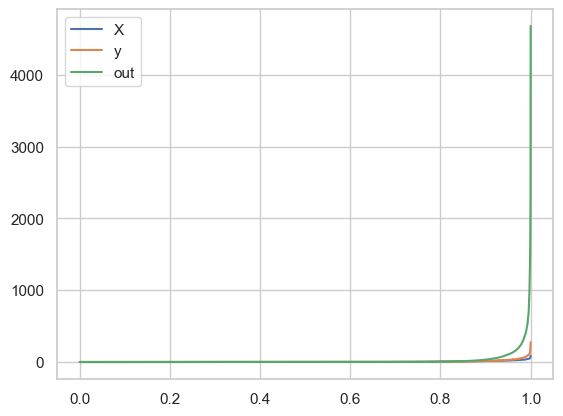

In [28]:
(X_train, X_test, y_train, y_test,pred)=BC(df,'pcp','Bcsd_Precipitation')

In [30]:
pred

<Axes: >

In [ ]:
# comment on fait pour savoir chronologie de donnees corrigees ?

In [ ]:
# test bcsd one more time

In [ ]:
climate_var_NEX_GDDP_CMIP6_EmplacementStation_BC=climate_var_NEX_GDDP_CMIP6_EmplacementStation[climate_var_NEX_GDDP_CMIP6_EmplacementStation['Name project']==name_station].drop(['Name project','Year','Month','Season'],axis =1)
climate_var_NEX_GDDP_CMIP6_EmplacementStation_BC_model = climate_var_NEX_GDDP_CMIP6_EmplacementStation_BC[climate_var_NEX_GDDP_CMIP6_EmplacementStation_BC['Model'] =='ACCESS-CM2'].drop(['Model'],axis=1)
training = climate_var_NEX_GDDP_CMIP6_EmplacementStation_BC_model.rename(columns = {'Date':'time','Mean of the daily precipitation rate mm/day':'pcp'}).reset_index()

# changing format of Date for training
Date1 = training['time'].values
for i in np.arange(0,len(training)):
    training['time'][i] = Date1[i][6:10]+'-'+Date1[i][3:5]+'-'+Date1[i][0:2]#datetime.strptime(, '%Y-%M-%d').date()
    print(training['time'][i])
# .date() to avoid having the hours in the datetime
training=training.set_index('time').drop(['index'],axis=1)


# targets
targets = data_obs_NOAA[['NAME','DATE','PRCP']] # select only 3 columns of interest
targets = targets[targets['NAME']==name_station].rename(columns = {'DATE':'time','PRCP':'pcp'}).set_index('time').drop(['NAME'],axis=1) # the targets data is meant to represent our "observations"


# to have the same size of vectors
targets = targets.dropna() # drop rows with NaN
training = training[training.index.isin(list(targets.index))]

In [ ]:
df=pd.concat({'training': training, 'targets': targets}, axis=1)

df=df.dropna()

In [ ]:
df = df.droplevel(1,axis=1)
df

In [ ]:
out=BCSD_Precipitation(df)

In [ ]:
out

In [ ]:
# return period before first BC
out3 = add_year_month_season(out.reset_index(),'time')
Z=out3.groupby('Year')[['pcp']].max()
(loc1,scale)=stats.gumbel_r.fit(Z) # return the function necessary to establish the continous function
# choice of gumbel because suits to extreme precipitation
#return_period.loc[(name_p,ssp,model),('Value for return period 50 years mm/day')] = 
#threshold_coresponding_to_return_period(loc1,scale,50) ## 113
#return_period.loc[(name_p,ssp,model),('Value for return period 100 years mm/day')] = 
threshold_coresponding_to_return_period(loc1,scale,100) # 124

In [ ]:
out=BCSD_Precipitation_one_more_time(df,out) # second time

In [ ]:
out

In [ ]:
out=BCSD_Precipitation_one_more_time(df,out) # third time

In [ ]:
out

In [ ]:
out=BCSD_Precipitation_one_more_time(df,out) # fourth time

In [ ]:
out3 = add_year_month_season(out.reset_index(),'time')

In [ ]:
out3

In [ ]:
Z=out3.groupby('Year')[['pcp']].max()

In [ ]:
out

In [ ]:
(loc1,scale)=stats.gumbel_r.fit(Z) # return the function necessary to establish the continous function
# choice of gumbel because suits to extreme precipitation
#return_period.loc[(name_p,ssp,model),('Value for return period 50 years mm/day')] = 
threshold_coresponding_to_return_period(loc1,scale,50) ## 220
#return_period.loc[(name_p,ssp,model),('Value for return period 100 years mm/day')] = 
#threshold_coresponding_to_return_period(loc1,scale,100) # 245

In [ ]:
out=BCSD_Precipitation_one_more_time(df,out) # fifth time

In [ ]:
out

In [ ]:
out = add_year_month_season(out.reset_index(),'time')

In [ ]:
Z=out.groupby('Year')[['pcp']].max()

In [ ]:
(loc1,scale)=stats.gumbel_r.fit(Z) # return the function necessary to establish the continous function
# choice of gumbel because suits to extreme precipitation
#return_period.loc[(name_p,ssp,model),('Value for return period 50 years mm/day')] = 
threshold_coresponding_to_return_period(loc1,scale,50) ## 245
#return_period.loc[(name_p,ssp,model),('Value for return period 100 years mm/day')] = 
#threshold_coresponding_to_return_period(loc1,scale,100) # 274